In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import librosa
import librosa.display
import import_ipynb
import helper_functions

from ipywidgets import *
import IPython.display as ipd
from ipywidgets import interactive
%matplotlib inline

In [6]:
# read from storage
filename = 'sounds/test.wav'
fs, data = wavfile.read(filename)

In [7]:
window_length_ms = 30
window_length = int(np.round(fs*window_length_ms/1000))
print(f"window_length: {window_length}")

n = np.linspace(0.5,window_length-0.5, num=window_length)

# windowing function
windowing_fn = np.sin(np.pi*n/window_length)**2 # sine-window

windowpos = np.random.randint(int((len(data)-window_length)))
print(f"windowpos: {windowpos}")

datawin = data[windowpos:(windowpos+window_length)]
print(f"datawin: {datawin.shape}")
datawin = datawin/np.max(np.abs(datawin)) # normalize

window_length: 1323
windowpos: 45022
datawin: (1323,)


# BASIC FOURIER LOG-SPECTRUM AND OTHER WAYS

In [8]:
spectrum = scipy.fft.rfft(datawin*windowing_fn)
f = np.linspace(0.,fs/2,num=len(spectrum))

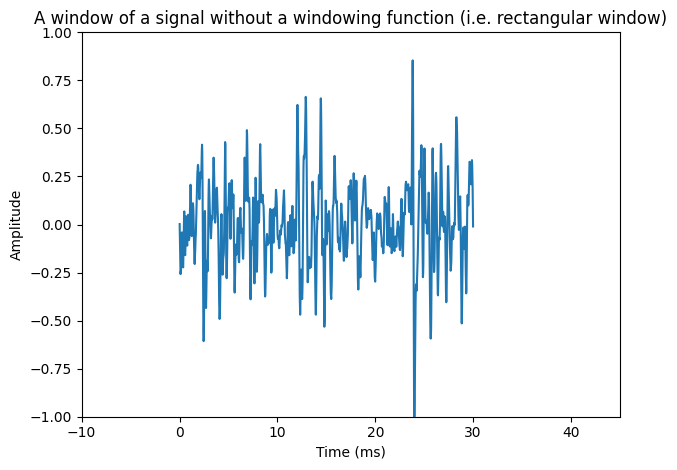

In [9]:
plt.plot(n*1000/fs,datawin)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('A window of a signal without a windowing function (i.e. rectangular window)')
plt.axis([-10.,45.,-1.,1.])
plt.tight_layout()
plt.show()

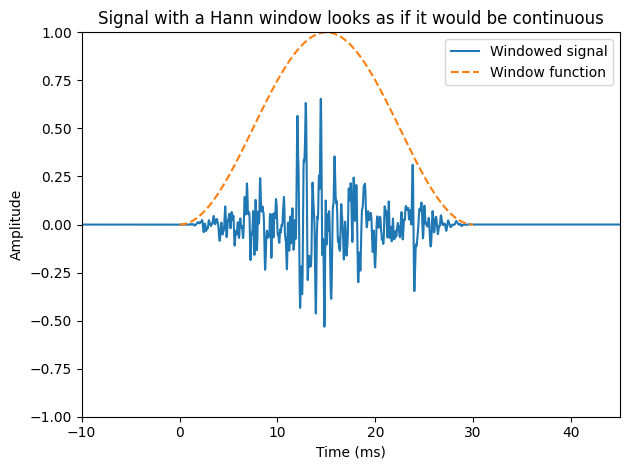

In [10]:
nx = np.concatenate(([-1000,0.],n,[window_length,window_length+1000]))
datax = np.concatenate(([0.,0.],datawin*windowing_fn,[0.,0.]))
plt.plot(nx*1000/fs,datax,label='Windowed signal')
plt.plot(n*1000/fs,windowing_fn,'--',label='Window function')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Signal with a Hann window looks as if it would be continuous')
plt.axis([-10.,45.,-1.,1.])
plt.tight_layout()
plt.show()

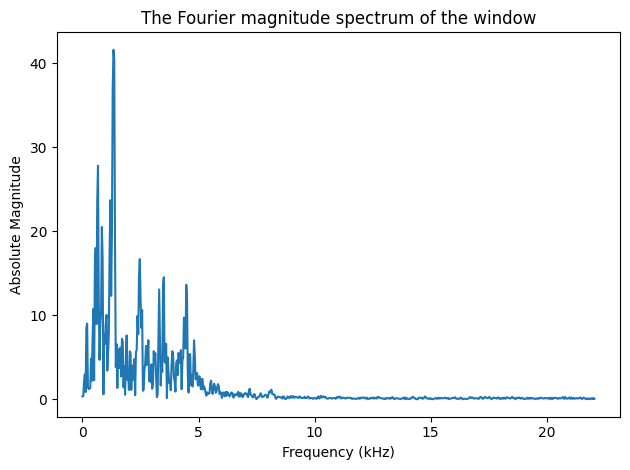

In [11]:
plt.plot(f/1000,np.abs(spectrum))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Absolute Magnitude')
plt.title('The Fourier magnitude spectrum of the window')
plt.tight_layout()
plt.show()

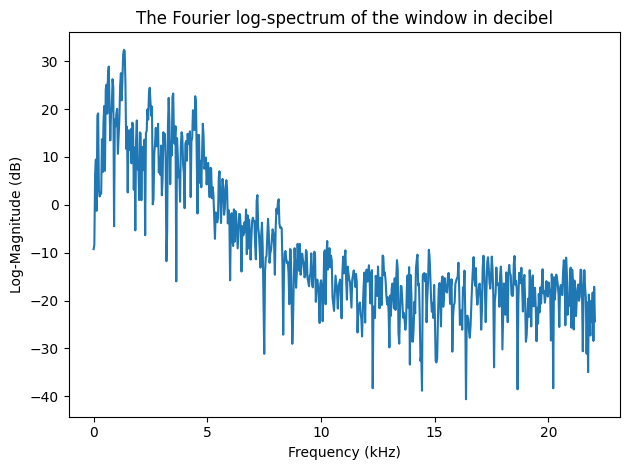

In [12]:
plt.plot(f/1000,20.*np.log10(np.abs(spectrum)))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Log-Magnitude (dB)')
plt.title('The Fourier log-spectrum of the window in decibel')
plt.tight_layout()
plt.show()

## INTERATIVE PLOT

In [ ]:
data = data.astype(np.int16)
data = data[:]
data_length = int(len(data))

def update_plot(position_s=0.5*data_length/fs, window_length_ms=30):
    ipd.clear_output(wait=True)
    window_length = int(window_length_ms*fs/1000)
    t = np.arange(0, data_length)/fs # Convert to seconds

    # Hann window
    window_fn = np.sin(np.pi*np.arange(0.5/window_length, 1, 1/window_length))**2

    window_position = int(position_s*fs)
    if window_position > data_length - window_length:
        window_position = data_length - window_length

    ix = window_position + np.arange(0, window_length, 1)
    window = data[ix] * window_fn

    X = scipy.fft.rfft(window.T, n=2*window_length)
    dft_length = len(X)
    f = np.arange(0, dft_length) * (fs/2000) /dft_length

    fig = plt.figure(figsize=(10, 8))
    #ax = fig.subplots(nrows=1,ncols=1)
    plt.subplot(311) # 311: 3 rows, 1 column, 1st plot
    plt.plot(t,data)
    plt.plot([position_s, position_s],[np.min(data), np.max(data)],'r--')
    plt.title('Whole signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(312) # 312: 3 rows, 1 column, 2nd plot
    plt.plot(t[ix],data[ix])
    plt.title('Selected window signal at postion (s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(313) # 313: 3 rows, 1 column, 3rd plot
    plt.plot(f,20.*np.log10(np.abs(X)))
    plt.title('Spectrum of window')
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Magnitude (dB)')
    plt.tight_layout()
    plt.show()
    fig.canvas.draw()

interactive_plot = interactive(update_plot, 
                            position_s=FloatSlider(min=0, max=data_length/fs, step=0.001, value=0.5*data_length/fs),
                            window_length_ms=IntSlider(min=2, max=300, step=0.5, value=30))
output = interactive_plot.children[-1]
output.layout.height = '800px'
style = {'description_width':'120px'}
interactive_plot.children[0].layout = Layout(width='760px')
interactive_plot.children[1].layout = Layout(width='760px')
interactive_plot.children[0].style=style
interactive_plot.children[1].style=style
interactive_plot

## SPECTROGRAM

In [ ]:
# read from storage
filename = 'sounds/test.wav'
fs, data_spectrogram = wavfile.read(filename)

ipd.display(ipd.HTML("Original audio"))
ipd.display(ipd.Audio(data_spectrogram, rate=fs))

# resample to 16kHz for better visualization
target_fs = 16000
data_resampled = scipy.signal.resample(data_spectrogram, len(data)*target_fs//fs)

ipd.display(ipd.HTML("After resampling"))
ipd.display(ipd.Audio(data_resampled, rate=target_fs))



#  window parameters in milliseconds
window_length_ms = 30
window_step_ms = 5

window_step = int(np.round(fs*window_step_ms/1000))
print(f"window_step: {window_step}")
window_length = int(np.round(fs*window_length_ms/1000))
print(f"window_length: {window_length}")
window_count = int(np.floor((data_resampled.shape[0]-window_length)/window_step) + 1)
print(f"window_count: {window_count}")

# Window function
window_fn = np.sin(np.pi*np.linspace(0.5, window_length-0.5, num=window_length)/window_length)**2 # Hann-window

spectrogram_matrix = np.zeros([window_length, window_count], dtype=complex)
for window_ix in range(window_count):
    data_window = np.multiply(window_fn, data_resampled[window_ix*window_step+np.arange(window_length)])
    spectrogram_matrix[:, window_ix] = np.fft.fft(data_window)

fft_length = int((window_length+1)/2)

t = np.arange(0., len(data_resampled), 1.)/target_fs
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(t, data_resampled)
plt.xlim([0, t[-1]])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Speech waveform")

plt.subplot(312)
plt.imshow(20*np.log10(0.2+np.abs(spectrogram_matrix[range(fft_length), :])), 
            origin="lower", 
            aspect="auto",
            extent=[0, len(data_resampled)/target_fs, 0., target_fs/2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)');
plt.title('Speech spectrogram')

plt.subplot(313)
plt.imshow(20*np.log10(0.2+np.abs(spectrogram_matrix[range(fft_length//2),: ])),
            origin="lower",
            aspect="auto",
            extent=[0, len(data_resampled)/target_fs, 0., target_fs/4000])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (kHz)")
plt.title("speech spectrogram zoomed into lower frequencies")
plt.tight_layout()
plt.show()


In [ ]:
filename = 'sounds/test.wav'
fs, data = wavfile.read(filename)
data = data.astype(np.int16)
data = data[:]
data_length = int(len(data))

def update_plot_spectrogram(window_length_ms=30, window_step_ms=15):
    ipd.clear_output(wait=True)
    window_length = int(window_length_ms*fs/1000.)
    window_step = int(window_step_ms*fs/1000.)
    window_count = (data_length - window_length)//window_step + 1
    dft_length = (window_length + 1)//2

    # Window function
    window_fn = np.sin(np.pi*np.arange(0.5/window_length, 1, 1/window_length))**2 # Hann-window

    windows = np.zeros([window_length, window_count])
    for k in range(window_count):
        ix = k*window_step + np.arange(0, window_length, 1)
        windows[:, k] = data[ix] * window_fn

    X = scipy.fft.rfft(windows, n=2*window_length, axis=0)
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.subplots(nrows=1, ncols=1)
    ax.imshow(20.*np.log10(1e-8+np.abs(X.T)), origin="lower", aspect="auto")
    plt.axis("auto")
    plt.show()
    fig.canvas.draw()

interactive_plot_spectrogram = interactive(update_plot_spectrogram, 
                                            window_length_ms=IntSlider(min=2., max=300., step=0.5, value=30),
                                            window_step_ms=IntSlider(min=1., max=50., step=0.01, value=15))
output_spectrogram = interactive_plot_spectrogram.children[-1]
output_spectrogram.layout.height = '350px'
interactive_plot_spectrogram

## Interpreting speech spectrograms

In [ ]:
# Speech decomposition code

speechfile = "sounds/temp.wav"
window_length_ms = 50
window_hop_ms = 3

def pow2dB(x):
    return 10.*np.log10(np.abs(x) + 1e-12)

def dB2pow(x):
    return 10.**(x/10.)

speech, fs = librosa.load(speechfile)
# Show original sound
ipd.display(ipd.HTML("Original sound"))
ipd.display(ipd.Audio(speech, rate=fs))

# Resample to 8kHz for better visualization
target_fs = 8000
speech = scipy.signal.resample(speech, len(speech)*target_fs//fs)
fs = target_fs
# Show sound after resampling for better visualization
ipd.display(ipd.HTML("Sound after resampling for bettern visualization"))
ipd.display(ipd.Audio(speech, rate=fs))


window_length = window_length_ms*fs//1000
spectrum_length = (window_length+2)//2
window_hop = window_hop_ms*fs//1000

filterbank, reconstruct = helper_functions.linearfilterbank(spectrum_length, fs/2, bandwidth_Hz=300)

speech = librosa.stft(speech, n_fft=window_length, hop_length=window_hop)

frame_cnt = speech.shape[1]
timebank, timereconstruct = helper_functions.linearfilterbank(frame_cnt, frame_cnt*window_hop_ms, bandwidth_Hz=120)

# Envelope
speechEnvelope = np.dot(reconstruct.T, np.dot(filterbank.T, np.abs(speech)**2))**0.5
fineFrequencyStructure = speech/speechEnvelope
speechEnvelopeTime = np.dot(timereconstruct.T, np.dot(timebank.T, np.abs(speechEnvelope.T)**2)).T**0.5
fineTimeEnvelope = speechEnvelope/speechEnvelopeTime
noise = np.random.randn(speechEnvelope.shape[0], speechEnvelope.shape[1])
speechFrequencyEnvelope = speechEnvelope*noise
speechFineTime = fineTimeEnvelope*noise
speechSmoothTime = speechEnvelopeTime*noise

speech_frequency_envelope = librosa.istft(speechFrequencyEnvelope, n_fft=window_length, hop_length=window_hop)
speech_fine_frequency = librosa.istft(fineFrequencyStructure, n_fft=window_length, hop_length=window_hop)
speech_smooth_time = librosa.istft(speechSmoothTime, n_fft=window_length, hop_length=window_hop)
speech_fine_time = librosa.istft(speechFineTime, n_fft=window_length, hop_length=window_hop)

# Plot spectrogram
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3))
D = librosa.amplitude_to_db(np.abs(speech), ref=np.max)
img = librosa.display.specshow(D, y_axis="linear", x_axis="time", sr=fs, hop_length=window_hop)
plt.title("Speech")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()



In [ ]:
# Keep formants

fix, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3))
D = librosa.amplitude_to_db(np.abs(speechEnvelope), ref=np.max)
img = librosa.display.specshow(D, y_axis="linear", x_axis="time", sr=fs, hop_length=window_hop)
plt.title("Frequency envelope")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

ipd.display(ipd.HTML("White noise shaped by the frequency envelope (i.e. harmonic structure is removed)"))
ipd.display(ipd.Audio(speech_frequency_envelope, rate=fs))

In [ ]:
# Keep harmonic
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3))
D = librosa.amplitude_to_db(np.abs(fineFrequencyStructure), ref=np.max)
img = librosa.display.specshow(D, y_axis="linear", x_axis="time", sr=fs, hop_length=window_hop)
plt.title("Speech envelope")
plt.xlabel("Time(s)")
plt.ylabel("Frequency(Hz)")
plt.show()

ipd.display(ipd.HTML("Harmonic Structure"))
ipd.display(ipd.Audio(speech_fine_frequency, rate=fs))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3))
D = librosa.amplitude_to_db(np.abs(speechEnvelopeTime), ref=np.max)
img = librosa.display.specshow(D, y_axis="linear", x_axis="time", sr=fs, hop_length=window_hop)
plt.title("Smoothed time")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

ipd.display(ipd.HTML("White noise shaped by smooth time structure"))
ipd.display(ipd.Audio(speech_smooth_time, rate=fs))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3))
D = librosa.amplitude_to_db(np.abs(fineTimeEnvelope), ref=np.max)
img = librosa.display.specshow(D, y_axis="linear", x_axis="time", sr=fs, hop_length=window_hop)
plt.title("Speech")
plt.xlabel("Time(s)")
plt.ylabel("Frequency(Hz)")
plt.show()

ipd.display(ipd.HTML("White noise shaped by fine time structure"))
ipd.display(ipd.Audio(speech_fine_time, rate=fs))